In [1]:
from dataclasses import dataclass, field
from vi import Agent, Config, Simulation, Vector2, HeadlessSimulation
import pygame as pg
import os
import numpy as np
import random
from multiprocessing import Pool
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)
frame_count = 0

def save_frame(screen):
    global frame_count
    pg.image.save(screen, os.path.join(frame_dir, f"frame_{frame_count:05d}.png"))
    frame_count += 1

In [3]:
class RecordingSimulation(Simulation):
    def __init__(self, config):
        super().__init__(config)
        self.frame_count = 0
        self.prey_predator_per_frame = []
        self.extinction_frame = None
        os.makedirs("frames", exist_ok=True)

    def after_update(self) -> None:
        # Draw everything to the screen
        self._all.draw(self._screen)

        if self.config.visualise_chunks:
            self.__visualise_chunks()

        # Save current frame as an image
        pg.image.save(self._screen, f"frames/frame_{self.frame_count:05d}.png")

        # Update the screen with the new image
        pg.display.flip()

        self._clock.tick(self.config.fps_limit)

        current_fps = self._clock.get_fps()
        if current_fps > 0:
            self._metrics.fps._push(current_fps)

            if self.config.print_fps:
                print(f"FPS: {current_fps:.1f}")  # noqa: T201

        # Increment a frame counter (you may need to initialize it somewhere)
        num_prey = len([agent for agent in self._all if isinstance(agent, Prey)])
        num_predator = len([agent for agent in self._all if isinstance(agent, Predator)])
        self.prey_predator_per_frame.append((num_prey, num_predator))
        if self.extinction_frame is None and num_predator == 0:
            self.extinction_frame = self.frame_count
            self.config.alpha = 0.0
        if self.extinction_frame is None and self.frame_count == self.config.duration:
            self.extinction_frame = self.frame_count
        if self.frame_count % 100 == 0:
            pass
            print(num_prey, num_predator)
        self.frame_count += 1


In [4]:
@dataclass
class PPConfig(Config):
    #desired initial populations
    initial_prey: int = 100
    initial_predators: int = 50

    #parameters of the Lotka-Volterra equations
    alpha = 0.0055    # slower prey reproduction
    beta = 0.015     # more effective predators
    delta = 0.8     # predator reproduction chance
    gamma = 0.005    # predator death chance

config = PPConfig(image_rotation = True, movement_speed = 3.0, radius = 25, duration = 60*60*3, fps_limit = 0)
    

In [5]:
class Prey(Agent):
    def on_spawn(self):
        self.flee_strength = 1.5
        self.join_strength = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 50
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()

        if random.random() < self.config.alpha:
            self.reproduce()

        flee_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())
        if any(isinstance(agent, Predator) for agent, _ in neighbors):
            self.state = "Flee"
        else:
            self.state = "Wander"


        if self.state == "Flee":
            self.wander_direction_cooldown = 0
            predators_nerby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Predator)]
            for predator, dist in predators_nerby:
                if dist == 0:
                    dist = 0.001
                direction = self.pos - predator.pos
                if dist > 0:
                    direction = direction / dist
                force_magnitude = self.flee_strength / dist
                flee_force += direction * force_magnitude
            
            self.move = flee_force
            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed


        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed
            else:
                self.wander_direction_cooldown -= 1
            
        self.pos += self.move

In [6]:
class Predator(Agent):
    def on_spawn(self):
        self.random_move_strength = 1.0
        self.predator_speed_boost = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 0
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()
        if random.random() < self.config.gamma:
            self.kill()
            return
        
        attract_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())

        if any(isinstance(agent, Prey) for agent, _ in neighbors):
            self.state = "Hunt"
        else:
            self.state = "Wander"

        if self.state == "Hunt":
            self.wander_direction_cooldown = 0
            prey_nearby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Prey)]
            the_closest_prey, closest_dist = min(prey_nearby, key=lambda x: x[1])
            if closest_dist == 0:
                    closest_dist = 0.001
            direction = the_closest_prey.pos - self.pos
                
            if closest_dist > 0:
                direction = direction / closest_dist

            force_magnitude = 1.0 / closest_dist
            attract_force += direction * force_magnitude
            if random.random() < self.config.beta and the_closest_prey.is_alive():
                the_closest_prey.kill()
                if random.random() < self.config.delta:
                    self.reproduce()
            
            self.move = attract_force

            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            
                

        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            else:
                self.wander_direction_cooldown -= 1
        
        self.pos += self.move

In [7]:
class God(Agent):
    """Class to keep simulation from crashing"""
    def on_spawn(self):
        self.move = Vector2(0,0)
        self.pos = Vector2(0,0)
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()

In [22]:
data = (
    RecordingSimulation(
        config
    )
    .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
    .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
    .batch_spawn_agents(1, God, images=["images/God.png"])
    .run()
)

extinction_time = data[1] / 3600

df = pd.DataFrame(data[0], columns=['Prey', 'Predator'])

df['Time'] = [t / 3600 for t in range(len(df))]

df_melted = df.melt(id_vars='Time', value_vars=['Prey', 'Predator'],
                    var_name='Species', value_name='Population')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Time', y='Population', hue='Species')
plt.title("Basic Predator-Prey Populations Over Time")
plt.xlabel("Simulation Minutes")
plt.ylabel("Population")
plt.axvline(x=data[1] / 3600, color='red', linestyle='--', label='Extinction')
plt.text(extinction_time + 0.1,                
         plt.ylim()[1] * 0.9,                  
         f"t = {extinction_time:.2f} min",     
         color='red')
plt.legend(title="Species")
plt.tight_layout()
plt.show()

101 50
118 70
123 91
146 109
128 131


KeyboardInterrupt: 

In [8]:
class HeadlessSimulationRefined(HeadlessSimulation):
   def __init__(self, config):
      super().__init__(config)
      self.frame_count = 0
      self.prey_predator_per_frame = []
      self.extinction_frame = None

   def after_update(self) -> None:
        # Increment a frame counter (you may need to initialize it somewhere)
        
        # if self.frame_count % 10 == 0:
        num_prey = len([agent for agent in self._all if isinstance(agent, Prey)])
        num_predator = len([agent for agent in self._all if isinstance(agent, Predator)])
        self.prey_predator_per_frame.append((num_prey, num_predator))
        if self.extinction_frame is None and num_predator == 0:
            self.extinction_frame = self.frame_count
            self.config.alpha = 0.0
        if self.extinction_frame is None and self.frame_count == self.config.duration:
            self.extinction_frame = self.frame_count
        if self.frame_count % 100 == 0:
            pass
            print(num_prey, num_predator)
        self.frame_count += 1

      

   def run(self):
        """Run the simulation until it's ended by closing the window or when the `vi.config.Schema.duration` has elapsed."""
        self._running = True

        while self._running:
            self.tick()

        return (self.prey_predator_per_frame, self.extinction_frame)

In [9]:
def run_simulation(config: Config) -> pl.DataFrame:
    return (
        HeadlessSimulationRefined(config)
        .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
        .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
        .batch_spawn_agents(1, God, images=["images/God.png"])
        .run()
    )

100 50
69 54
45 43
28 34
21 21
16 16
13 14
12 6
11 6
11 3
10 1
10 1
10 1
9 2
9 1
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0
9 0


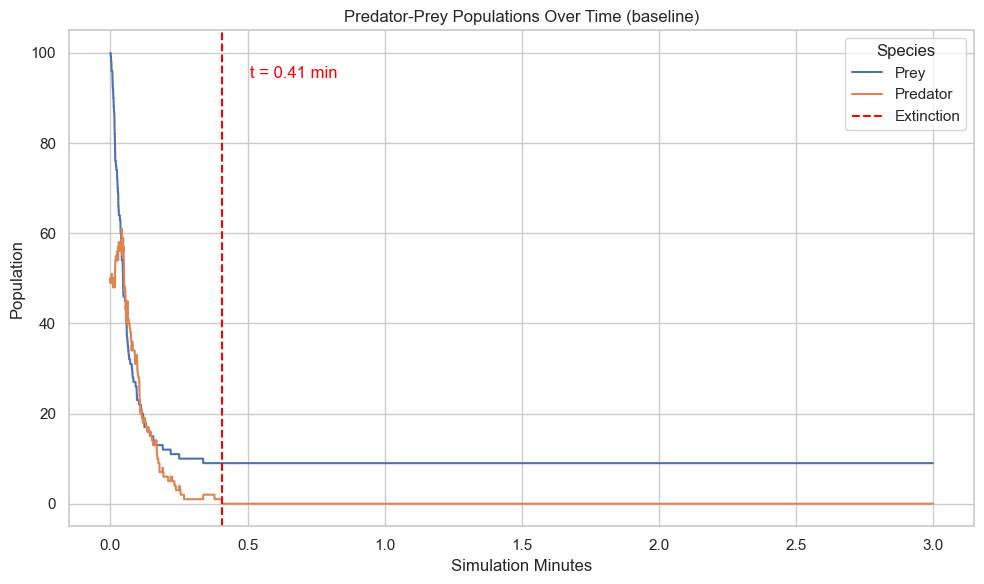

In [13]:
data= run_simulation(config)
extinction_time = data[1] / 3600

df = pd.DataFrame(data[0], columns=['Prey', 'Predator'])

df['Time'] = [t / 3600 for t in range(len(df))]

df_melted = df.melt(id_vars='Time', value_vars=['Prey', 'Predator'],
                    var_name='Species', value_name='Population')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Time', y='Population', hue='Species')
plt.title("Predator-Prey Populations Over Time (baseline)")
plt.xlabel("Simulation Minutes")
plt.ylabel("Population")
plt.axvline(x=data[1] / 3600, color='red', linestyle='--', label='Extinction')
plt.text(extinction_time + 0.1,                
         plt.ylim()[1] * 0.9,                  
         f"t = {extinction_time:.2f} min",     
         color='red')
plt.legend(title="Species")
plt.tight_layout()
plt.show()

In [ ]:
all_data = []

for run_id in range(30):
    print(f"{run_id * 100 // 30} %")
    history, extinction_time = run_simulation(config)
    
    for t, (prey, predator) in enumerate(history):
        all_data.append({
            'Run': run_id,
            'Time': t,
            'Prey': prey,
            'Predator': predator,
            'ExtinctionTime': extinction_time
        })

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Save to CSV
df.to_csv('simulation_results.csv', index=False)

0 %
100 50
72 57
44 50
33 35
28 22
24 17
18 15
13 15
13 6
13 4
13 3
13 3
13 2
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
13 0
3 %
100 50
69 47
43 45
30 41
27 23
24 16
21 9
20 5
20 1
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
20 0
2

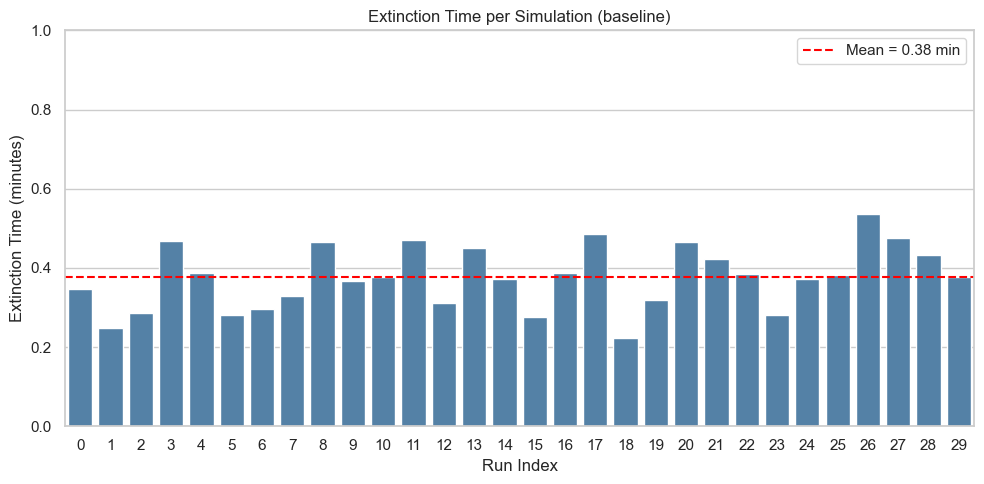

In [30]:
df = pd.read_csv('basic-simulation_results.csv')
extinction_times = df.groupby('Run')['ExtinctionTime'].first().reset_index()
extinction_times['ExtinctionTimeMin'] = extinction_times['ExtinctionTime'] / 3600

plt.figure(figsize=(10, 5))
sns.barplot(data=extinction_times, x='Run', y='ExtinctionTimeMin', color='steelblue')

mean_ext = extinction_times['ExtinctionTimeMin'].mean()
plt.axhline(mean_ext, color='red', linestyle='--', label=f'Mean = {mean_ext:.2f} min')

plt.title("Extinction Time per Simulation (baseline)")
plt.xlabel("Run Index")
plt.ylabel("Extinction Time (minutes)")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()
